
#### 1. IMPORT LIB


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from deep_translator import GoogleTranslator
from unidecode import unidecode
from pymongo import UpdateOne
from textblob import TextBlob
from wordcloud import WordCloud
import time

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_theme(
    style="whitegrid",
    palette="Set2",
    font_scale=1.1)

plt.rcParams["figure.figsize"] = (10, 6)

#### 2. CONNECT & LOAD DATA

In [8]:
client = MongoClient("mongodb://localhost:27017/")
db = client["Goodreads"]
books_col = db["books"]
reviews_col = db["reviews"]

# TRANSLATOR
translator = GoogleTranslator(source="en", target="vi")

# LOAD BOOKS
books_cursor = books_col.find()

books_data = []
for b in books_cursor:
    books_data.append({
        "book_id": b.get("_id"),
        "title": b.get("title"),
        "author": b.get("author"),
        "publish_year": b.get("publish_year"),
        "avg_rating": b.get("avg_rating"),
        "review_count": b.get("review_count"),
        "review_count_crawled": b.get("review_count_crawled"),
        "genres": b.get("genres"),
        "book_url": b.get("book_url")
    })

df_books = pd.DataFrame(books_data)

In [9]:
df_books.head()

,book_id,title,author,publish_year,avg_rating,review_count,review_count_crawled,genres,book_url
0,GR_10534,The Art of War,Sun Tzu,NaN,3.95,566644,100,[art],https://www.goodreads.com/book/show/10534.The_...
1,GR_1633,Getting Things Done: The Art of Stress-Free Pr...,David Allen,2001.0,4.00,167407,100,[art],https://www.goodreads.com/book/show/1633.Getti...
2,GR_22318578,The Life-Changing Magic of Tidying Up: The Jap...,Marie Kondō,2010.0,3.88,391098,100,[art],https://www.goodreads.com/book/show/22318578-t...
3,GR_15751404,"David and Goliath: Underdogs, Misfits, and the...",Malcolm Gladwell,2013.0,3.97,191237,100,[art],https://www.goodreads.com/book/show/15751404-d...
4,GR_28257707,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,2016.0,3.87,1389048,100,[art],https://www.goodreads.com/book/show/28257707-t...


In [10]:
# LOAD REVIEWS
reviews_cursor = reviews_col.find()

reviews_data = []
for r in reviews_cursor:
    reviews_data.append({
        "review_id": r.get("_id"),
        "book_id": r.get("book_id"),
        "text": r.get("text"),
        "text_vi": r.get("text_vi"),
        "genres": r.get("genres"),
        "created_at": r.get("created_at")
    })
df_reviews = pd.DataFrame(reviews_data)
df_reviews.head()

,review_id,book_id,text,text_vi,genres,created_at
0,953e6d52faabe16933c56d9d8986c359,GR_10534,Hey! Look at me stepping outside my comfort zo...,"Này, hãy nhìn vào tôi, tôi đã tìm thấy một cuố...",[art],2025-12-27
1,6e2842b7bfea2392814604e199a9aaa8,GR_10534,"Simply put, Sun Tzu says that it is better not...","Chỉ cần đưa ra một cách đơn giản, Sun Tzu nói ...",[art],2025-12-27
2,5da6de39f9eee396de0ee88949defe65,GR_10534,I definitely never thought i'd want to read a ...,Tôi chưa bao giờ nghĩ rằng tôi muốn đọc một cu...,[art],2025-12-27
3,53930641e84455aa608ab3270fd9890b,GR_10534,The Art of Goodreads 1. Lotz says: The greates...,"Nếu bạn không bao giờ đọc được cuốn sách này, ...",[art],2025-12-27
4,ed21e5c82b78503b0ba201ee0a8be6a2,GR_10534,I thought this would contain more wisdom than ...,Tôi nghĩ điều này có chứa đựng nhiều sự khôn n...,[art],2025-12-27


#### 3. XỬ LÝ DỮ LIỆU (DATA PROCESSING / CLEANING)

##### Kiểm tra & loại bỏ dữ liệu trùng lặp

In [11]:
df_books = df_books.drop_duplicates(subset="book_id")

df_reviews = df_reviews.drop_duplicates(subset="review_id")

##### Chuẩn hóa dữ liệu text (author, genres)

In [12]:
# Chuẩn hóa tên tác giả (lowercase, strip)
df_books["author_clean"] = (
    df_books["author"]
    .str.lower()
    .str.strip())

# Chuẩn hóa thể loại (genres)
df_books["genres_clean"] = (
    df_books["genres"]
    .apply(lambda x: [g.lower().strip() for g in x] if isinstance(x, list) else []))

##### Xử lý giá trị thiếu (Missing Values)

In [13]:
df_books.columns

Index(['book_id', 'title', 'author', 'publish_year', 'avg_rating', 'review_count', 'review_count_crawled', 'genres', 'book_url', 'author_clean', 'genres_clean'], dtype='object')

In [14]:
df_books["publish_year"] = df_books["publish_year"].fillna(
    df_books["publish_year"].median())

df_books["avg_rating"] = df_books["avg_rating"].fillna(
    df_books["avg_rating"].mean())

# df_books["cover_image"] = df_books["cover_image"].fillna("no_image")

##### Làm sạch review text

In [15]:
# Loại bỏ review quá ngắn
df_reviews["review_length"] = df_reviews["text"].str.len()

df_reviews = df_reviews[df_reviews["review_length"] >= 30]

# Chuẩn hóa text review
df_reviews["text_clean"] = (
    df_reviews["text"]
    .str.lower()
    .str.replace(r"[^\w\s]", "", regex=True))
df_reviews.head()

,review_id,book_id,text,text_vi,genres,created_at,review_length,text_clean
0,953e6d52faabe16933c56d9d8986c359,GR_10534,Hey! Look at me stepping outside my comfort zo...,"Này, hãy nhìn vào tôi, tôi đã tìm thấy một cuố...",[art],2025-12-27,3693,hey look at me stepping outside my comfort zon...
1,6e2842b7bfea2392814604e199a9aaa8,GR_10534,"Simply put, Sun Tzu says that it is better not...","Chỉ cần đưa ra một cách đơn giản, Sun Tzu nói ...",[art],2025-12-27,1000,simply put sun tzu says that it is better not ...
2,5da6de39f9eee396de0ee88949defe65,GR_10534,I definitely never thought i'd want to read a ...,Tôi chưa bao giờ nghĩ rằng tôi muốn đọc một cu...,[art],2025-12-27,172,i definitely never thought id want to read a b...
3,53930641e84455aa608ab3270fd9890b,GR_10534,The Art of Goodreads 1. Lotz says: The greates...,"Nếu bạn không bao giờ đọc được cuốn sách này, ...",[art],2025-12-27,2141,the art of goodreads 1 lotz says the greatest ...
4,ed21e5c82b78503b0ba201ee0a8be6a2,GR_10534,I thought this would contain more wisdom than ...,Tôi nghĩ điều này có chứa đựng nhiều sự khôn n...,[art],2025-12-27,226,i thought this would contain more wisdom than ...


#### PHÂN TÍCH DỮ LIỆU (DATA ANALYSIS / EXPLORATION)

##### 1. Số lượng sách theo thể loại

In [16]:
len(df_books)

7412

In [17]:
genre_count = (
    df_books
    .explode("genres_clean")
    .groupby("genres_clean")
    .size()
    .reset_index(name="num_books")
    .sort_values("num_books", ascending=False))

print ("Số lượng sách theo thể loại")
genre_count.head(10)

Số lượng sách theo thể loại


,genres_clean,num_books
0,art,242
4,christian,239
16,humor,238
21,nonfiction,237
19,music,237
3,chick-lit,235
2,business,235
26,science,234
24,religion,232
11,fiction,232


##### 2. Sách có rating trung bình cao nhất / thấp nhất

In [18]:
print ("Sách có rating trung bình cao nhất")
df_books.sort_values("avg_rating", ascending=False)[
    ["title", "author", "avg_rating", "review_count"]
].head(10)

Sách có rating trung bình cao nhất


,title,author,avg_rating,review_count
1699,"Evie (Socially Awkward Lonely-Hearts Club, Par...",Felicia Mires,5.0,1
1707,The Lad-Lit Series Boxset 1-3: Chick-lit's Nau...,Rob Radcliffe,5.0,1
1690,Socially Awkward Lonely-Hearts Club: A Christi...,Felicia Mires,5.0,1
1782,New York Toy: The Not-So-Small Adventures of O...,Alexis Leigh,5.0,1
6232,The Parent Pivot: What to Do When Your Young A...,Lynne Carroll,5.0,2
1648,I Will Marry You: Chick Lit Romace Novel,Fei You You,5.0,2
1618,Love and Romance for Kids: A Child-Friendly Ch...,Jeff Child,5.0,2
1764,Sarcastic Husbands,Crystal Gabrielle,5.0,2
1739,How to Test a Good Girl,Crystal Gabrielle,5.0,1
1759,"Sydney (Socially Awkward Lonely-Hearts Club, P...",Felicia Mires,5.0,1


In [19]:
print ("Sách có rating trung bình thấp nhất")
df_books.sort_values("avg_rating", ascending=True)[
    ["title", "author", "avg_rating", "review_count"]
].head(10)


Sách có rating trung bình thấp nhất


,title,author,avg_rating,review_count
1686,Mistaken Love With Mysterious CEO: Chick Lit R...,yao xiao yao,0.0,0
1666,Little Red Dress: A Christmas Romance,Camilla Hope,0.0,0
1783,President's Substitute Wife: Chick Lit Romace ...,Wei Hu,0.0,0
1781,Cat Scratch Fever and Other Stories: Macey Mal...,Jada Ryker,0.0,0
1665,President's Substitute Wife: Chick Lit Romace ...,Wei Hu,0.0,0
4969,Dirty Tennis: A Reference for Some of Tennis's...,Beth Mignano,0.0,0
1706,"THE GYPSY WARNED YOU!: A LIGHT HEARTED, SUPERN...",Carol Prior,0.0,0
1751,"Litterature Feminine: Chick Lit, Collection de...",Source Wikipedia,0.0,0
1718,"No eres tú, soy yo: Un chick-lit al más puro e...",Eleanor Rigby,0.0,0
1716,Ohlala Camille !! - Learn French with chick li...,Lynette Chauvirey,0.0,0


##### 3. Số lượng review trung bình theo thể loại

In [20]:
genre_review_avg = (
    df_books
    .explode("genres_clean")
    .groupby("genres_clean")["review_count"]
    .mean()
    .reset_index(name="avg_review_count")
    .sort_values("avg_review_count", ascending=False)
)

print ("Số lượng review trung bình theo thể loại")
genre_review_avg.head(10)

Số lượng review trung bình theo thể loại


,genres_clean,avg_review_count
0,art,78403.252066
5,classics,76414.308411
14,history,47955.597345
23,psychology,42369.250000
18,memoir,36007.339367
7,contemporary,30294.466667
34,young-adult,25409.381579
33,travel,21305.097345
20,mystery,20115.729358
9,crime,17589.415929


##### 4. Top 10 sách được đánh giá nhiều nhất

In [21]:
print("Top 10 sách được đánh giá nhiều nhất")
df_books.sort_values("review_count", ascending=False)[
    ["title", "author", "review_count", "avg_rating"]
].head(10)

Top 10 sách được đánh giá nhiều nhất


,title,author,review_count,avg_rating
6514,"Pride and Prejudice, Annotated: Jane Austen's ...",Jane Austen,4760868,4.29
3038,Jane Eyre: The Original 1847 Unabridged and Co...,Charlotte Brontë,2308388,4.16
12,Memoirs of a Geisha,Arthur Golden,2103426,4.16
3777,Wuthering Heights,Emily Brontë,2025457,3.90
3242,Frankenstien (4),Mary Wollstonecraft Shelley,1864259,3.90
3919,Frankenstein,Mary Wollstonecraft Shelley,1864259,3.90
2944,The Picture of Dorian Gray: Annotated Edition,Oscar Wilde,1857393,4.13
5642,The Time Traveler's Wife,Audrey Niffenegger,1854353,4.00
3058,Dracula,Bram Stoker,1464836,4.02
4,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,1389048,3.87


##### 5. Top 10 sách có rating cao nhất

In [22]:
print("Top 10 sách có rating cao nhất (lọc sách đủ review)")

# Lọc sách có đủ review
top_rated = df_books[df_books["review_count"] >= 1000]

top_rated.sort_values("avg_rating", ascending=False)[
    ["title", "author", "avg_rating", "review_count"]
].head(10)

Top 10 sách có rating cao nhất (lọc sách đủ review)


,title,author,avg_rating,review_count
2722,Three James Herriot Classics: Volume 1,James Herriot,4.78,3858
5157,文豪ストレイドッグス BEAST 4,Shiwasu Hoshikawa(Adaptor),4.77,1417
5630,Fantasy in Death / Indulgence in Death / Treac...,J.D. Robb,4.73,2616
2214,The Only Plane in the Sky: An Oral History of ...,Garrett M. Graff,4.72,44094
2403,"Foster the Family: Encouragement, Hope, and Pr...",Jamie C. Finn,4.72,1454
7152,The Only Plane in the Sky: An Oral History of ...,Garrett M. Graff,4.72,44096
7003,Invisible Child: Winner of the Pulitzer Prize ...,Andrea Elliott,4.70,19156
2135,How the Word Is Passed: A Reckoning with the H...,Clint Smith,4.70,39300
5830,Know My Name: A Memoir,Chanel Miller,4.68,255246
3800,Refuge of Redemption: The Colsons,Christy Barritt,4.68,1151


#### TRỰC QUAN HÓA (VISUALIZATION)

##### 1. Biểu đồ cột – Số sách theo thể loại

C:\Users\NHU\AppData\Local\Temp\ipykernel_1428\286890374.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


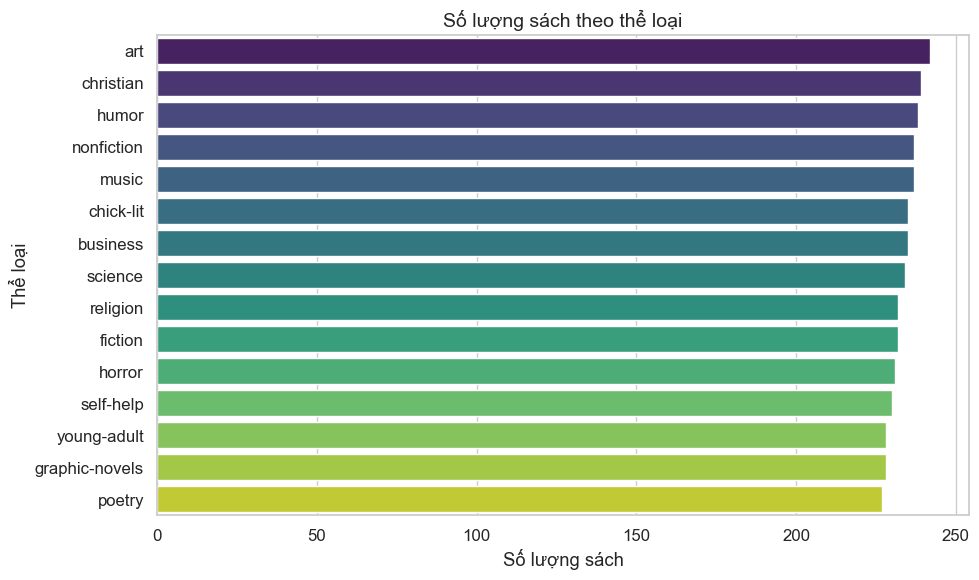

In [23]:
genre_count = (
    df_books
    .explode("genres_clean")
    .groupby("genres_clean")
    .size()
    .reset_index(name="Số lượng sách")
    .sort_values("Số lượng sách", ascending=False))

plt.figure()
sns.barplot(
    data=genre_count.head(15),
    x="Số lượng sách",
    y="genres_clean", palette='viridis')

plt.title("Số lượng sách theo thể loại", fontsize=14)
plt.xlabel("Số lượng sách")
plt.ylabel("Thể loại")
plt.tight_layout()
plt.show()

##### 2. Boxplot – Phân bố rating theo thể loại

C:\Users\NHU\AppData\Local\Temp\ipykernel_1428\1746307624.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


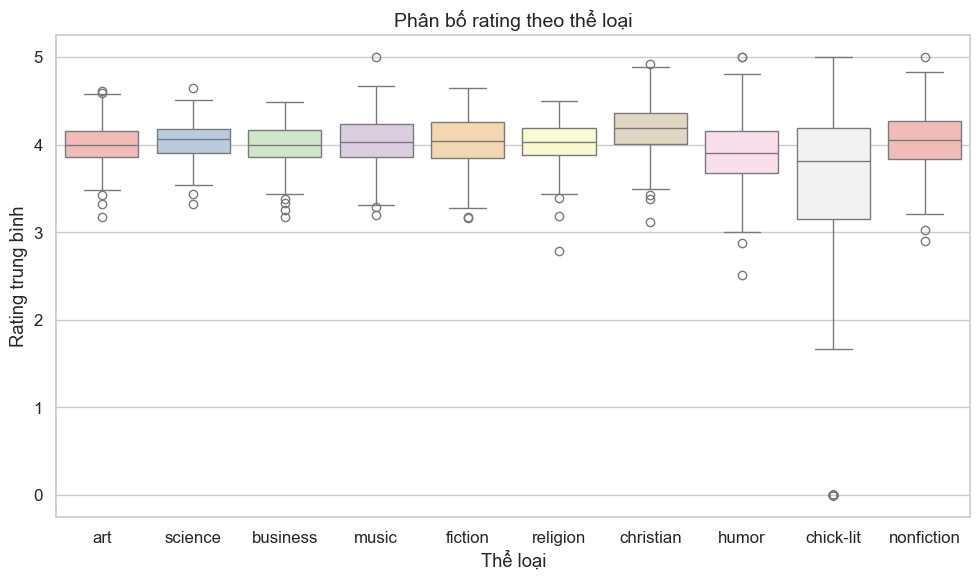

In [24]:
rating_genre = df_books.explode("genres_clean")

plt.figure()
sns.boxplot(
    data=rating_genre[rating_genre["genres_clean"].isin(
        genre_count.head(10)["genres_clean"],
    )],
    x="genres_clean",
    y="avg_rating", palette='Pastel1')

plt.title("Phân bố rating theo thể loại", fontsize=14)
plt.xlabel("Thể loại")
plt.ylabel("Rating trung bình")
plt.tight_layout()
plt.show()

##### 3. Biểu đồ tròn – Tỷ lệ review theo thể loại

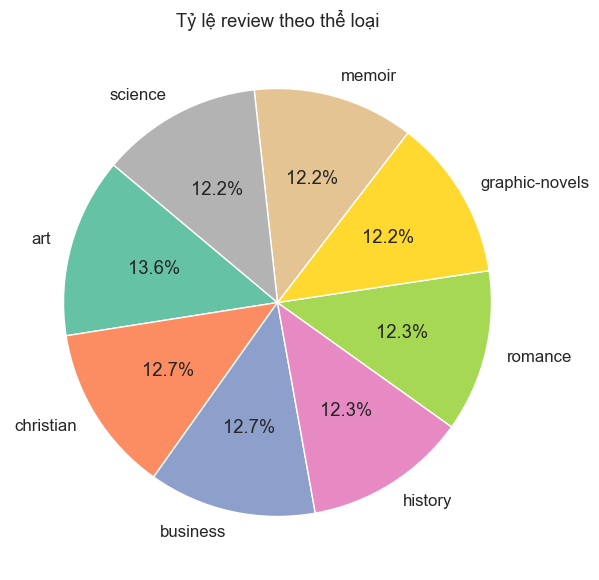

In [25]:
review_by_genre = (
    df_reviews
    .explode("genres")
    .groupby("genres")
    .size()
    .reset_index(name="Số lượng review")
    .sort_values("Số lượng review", ascending=False))

plt.figure()
plt.pie(
    review_by_genre.head(8)["Số lượng review"],
    labels=review_by_genre.head(8)["genres"],
    autopct="%1.1f%%",
    startangle=140)

plt.title("Tỷ lệ review theo thể loại")
plt.tight_layout()
plt.show()

#### TRUY VẤN NÂNG CAO / BÀI TOÁN THỰC TẾ

##### 1. Tìm tất cả review của 1 sách cụ thể

In [37]:
book_name = "Memoirs of a Geisha"

book_id = df_books[df_books["title"] == book_name]["book_id"].iloc[0]

df_reviews[df_reviews["book_id"] == book_id][
    ["text", "created_at"]
].head(10)

,text,created_at
360,So.. Memoirs of a Geisha. I'd been wanting to ...,2025-12-27
361,"Memoirs of a Geisha is an American novel, and ...",2025-12-27
362,Like eating fancy dessert at a gourmet restaur...,2025-12-27
363,"”Whatever our struggles and triumphs, however ...",2025-12-27
364,Arthur Golden’s Memoirs of a Geisha is set in ...,2025-12-27
365,Damn if you aren't one of the most problematic...,2025-12-27
366,A timeless genre picture of a strong woman mak...,2025-12-27
367,This book was wonderful. I absolutely love the...,2025-12-27
368,I read this a long time ago ---(a favorite) --...,2025-12-27
369,I became fascinated with Japanese culture when...,2025-12-27


##### 2. Tìm review theo thể loại

In [39]:
genre_search = "art"

df_reviews[
    df_reviews["genres"].apply(lambda x: genre_search in x)
][["text_vi", "book_id"]].head(10)

,text_vi,book_id
0,"Này, hãy nhìn vào tôi, tôi đã tìm thấy một cuố...",GR_10534
1,"Chỉ cần đưa ra một cách đơn giản, Sun Tzu nói ...",GR_10534
2,Tôi chưa bao giờ nghĩ rằng tôi muốn đọc một cu...,GR_10534
3,"Nếu bạn không bao giờ đọc được cuốn sách này, ...",GR_10534
4,Tôi nghĩ điều này có chứa đựng nhiều sự khôn n...,GR_10534
5,"Khi tôi đi làm, tôi chắc chắn sẽ nói về mục ti...",GR_10534
6,Tôi không bao giờ nghĩ rằng những điều này có ...,GR_10534
7,Nếu bất cứ ai đang tìm kiếm một tướng quân chi...,GR_10534
8,"Nếu chúng ta có thể tìm hiểu về vấn đề này, th...",GR_10534
9,Chiến thắng lớn nhất là không cần phải chiến t...,GR_10534


##### 3. Tìm review chứa từ khóa tiêu cực / tích cực

In [28]:
# Hàm tính điểm cảm xúc (-1 là rất tiêu cực, 1 là rất tích cực)
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

df_reviews["sentiment_score"] = df_reviews["text"].apply(get_sentiment)

# Phân loại dựa trên điểm số
def phan_loai_cam_xuc(score):
    if score > 0.1: return "Tích cực"
    elif score < -0.1: return "Tiêu cực"
    else: return "Trung tính"

df_reviews["Cảm xúc"] = df_reviews["sentiment_score"].apply(phan_loai_cam_xuc)

print(df_reviews[["text", "Cảm xúc"]].head())

                                                text     Cảm xúc
0  Hey! Look at me stepping outside my comfort zo...  Trung tính
1  Simply put, Sun Tzu says that it is better not...    Tích cực
2  I definitely never thought i'd want to read a ...  Trung tính
3  The Art of Goodreads 1. Lotz says: The greates...    Tích cực
4  I thought this would contain more wisdom than ...    Tích cực


##### 4. Xếp hạng sách theo độ phổ biến

In [29]:
print ("Theo số lượng review")
top_popular = df_books.sort_values(
    "review_count", ascending=False
)[["title", "author", "review_count", "avg_rating"]].head(10)

top_popular.columns = ["title", "author", "review_count", "avg_rating"]

top_popular

Theo số lượng review


,title,author,review_count,avg_rating
6514,"Pride and Prejudice, Annotated: Jane Austen's ...",Jane Austen,4760868,4.29
3038,Jane Eyre: The Original 1847 Unabridged and Co...,Charlotte Brontë,2308388,4.16
12,Memoirs of a Geisha,Arthur Golden,2103426,4.16
3777,Wuthering Heights,Emily Brontë,2025457,3.90
3242,Frankenstien (4),Mary Wollstonecraft Shelley,1864259,3.90
3919,Frankenstein,Mary Wollstonecraft Shelley,1864259,3.90
2944,The Picture of Dorian Gray: Annotated Edition,Oscar Wilde,1857393,4.13
5642,The Time Traveler's Wife,Audrey Niffenegger,1854353,4.00
3058,Dracula,Bram Stoker,1464836,4.02
4,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,1389048,3.87


In [30]:
print("Theo chất lượng (rating cao + đủ review)")
top_quality = df_books[df_books["review_count"] >= 1000] \
    .sort_values("avg_rating", ascending=False) \
    [["title", "author", "avg_rating", "review_count"]] \
    .head(10)

top_quality.columns = ["title", "author", "avg_rating", "review_count"]

top_quality

Theo chất lượng (rating cao + đủ review)


,title,author,avg_rating,review_count
2722,Three James Herriot Classics: Volume 1,James Herriot,4.78,3858
5157,文豪ストレイドッグス BEAST 4,Shiwasu Hoshikawa(Adaptor),4.77,1417
5630,Fantasy in Death / Indulgence in Death / Treac...,J.D. Robb,4.73,2616
2214,The Only Plane in the Sky: An Oral History of ...,Garrett M. Graff,4.72,44094
2403,"Foster the Family: Encouragement, Hope, and Pr...",Jamie C. Finn,4.72,1454
7152,The Only Plane in the Sky: An Oral History of ...,Garrett M. Graff,4.72,44096
7003,Invisible Child: Winner of the Pulitzer Prize ...,Andrea Elliott,4.70,19156
2135,How the Word Is Passed: A Reckoning with the H...,Clint Smith,4.70,39300
5830,Know My Name: A Memoir,Chanel Miller,4.68,255246
3800,Refuge of Redemption: The Colsons,Christy Barritt,4.68,1151


##### 5. Biểu đồ xếp hạng sách phổ biến nhất

C:\Users\NHU\AppData\Local\Temp\ipykernel_1428\3472763478.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\NHU\AppData\Local\Temp\ipykernel_1428\3472763478.py:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


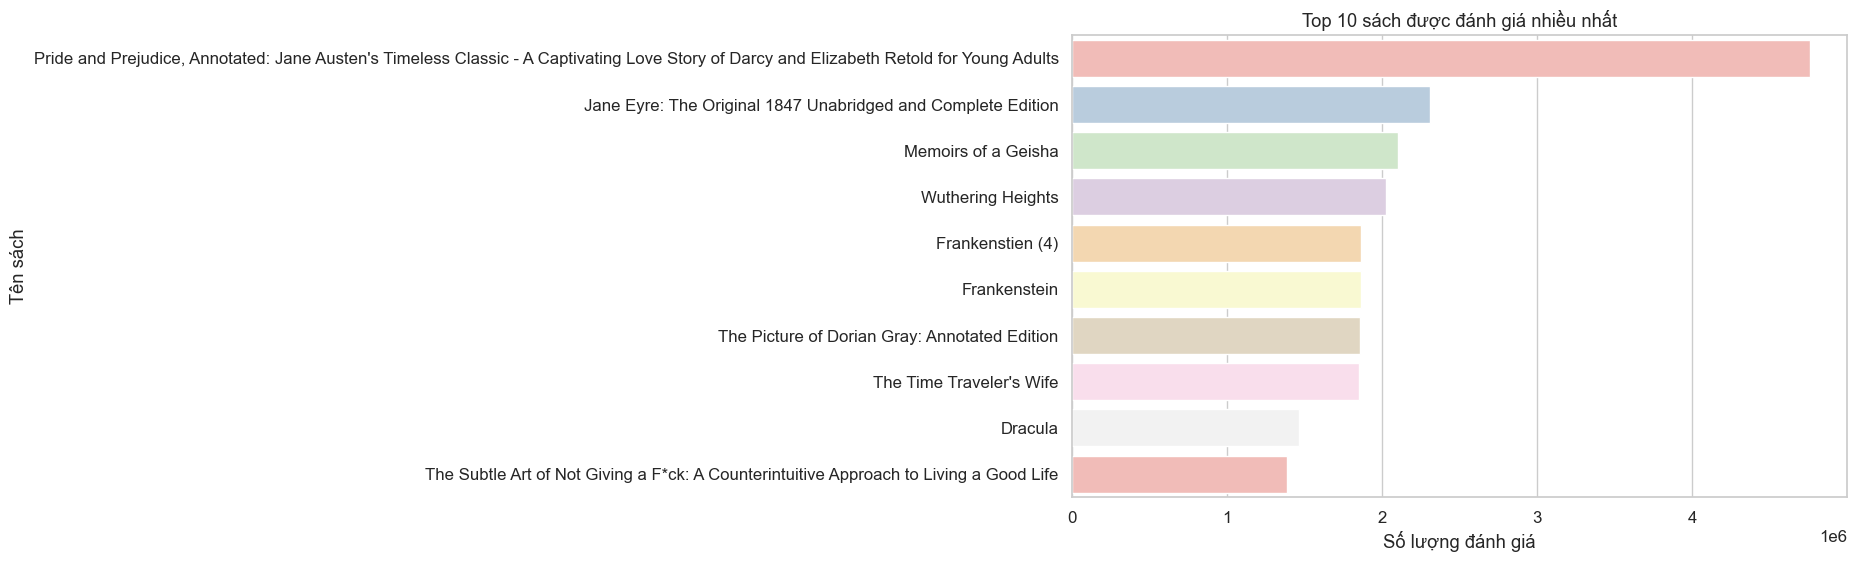

In [31]:
plt.figure()
sns.barplot(
    data=top_popular,
    x="review_count",
    y="title", palette='Pastel1')

plt.title("Top 10 sách được đánh giá nhiều nhất")
plt.xlabel("Số lượng đánh giá")
plt.ylabel("Tên sách")
plt.tight_layout()
plt.show()

##### 6. Biểu đồ WordCloud

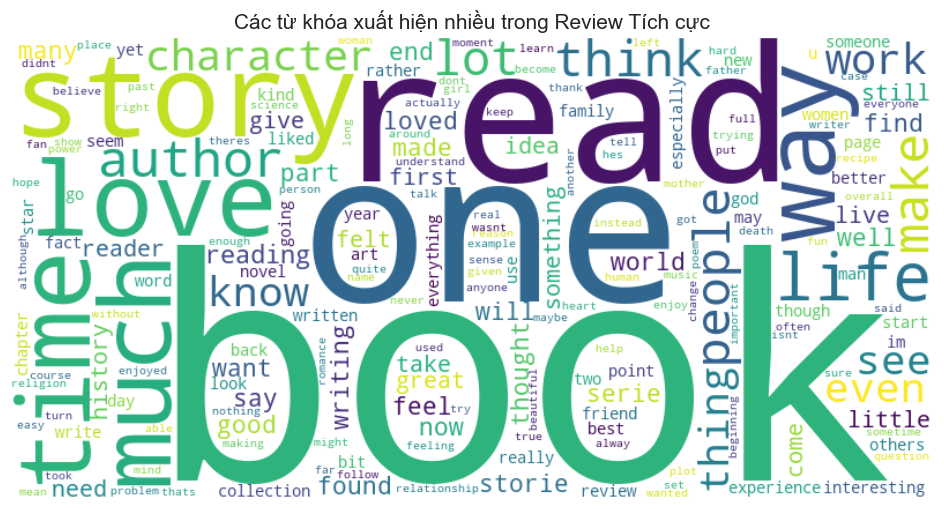

In [32]:
# Lấy toàn bộ text từ các review tích cực
text_positive = " ".join(review for review in df_reviews[df_reviews["Cảm xúc"]=="Tích cực"]["text_clean"])

# Tạo WordCloud
wc = WordCloud(width=800, height=400, background_color ='white', colormap='viridis').generate(text_positive)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Các từ khóa xuất hiện nhiều trong Review Tích cực", fontsize=15)
plt.show()

##### 7. Biểu đồ Scatter Plot (Tương quan giữa độ nổi tiếng và chất lượng)

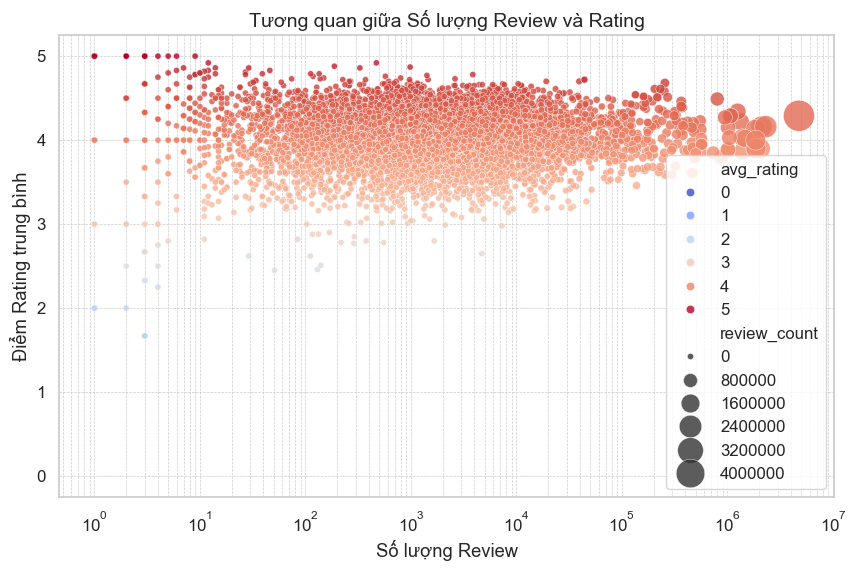

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_books,
    x="review_count",
    y="avg_rating",
    alpha= 0.8,
    hue="avg_rating",
    palette="coolwarm",
    size="review_count",
    sizes=(20, 500),
)

plt.title("Tương quan giữa Số lượng Review và Rating", fontsize=14)
plt.xlabel("Số lượng Review")
plt.ylabel("Điểm Rating trung bình")
plt.xscale('log') # Dùng log scale nếu chênh lệch review quá lớn
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

##### 8. Tính năng "Gợi ý sách"

In [34]:
# Gợi ý sách cùng thể loại có rating cao nhất
def recommend_books(genre_input, top_n=5):
    # Lọc sách theo thể loại
    books_genre = df_books[df_books["genres_clean"].apply(lambda x: genre_input.lower() in x)]

    if books_genre.empty:
        return "Không tìm thấy sách thể loại này!"

    # Sắp xếp theo rating và lượng review (để tránh sách 5 sao nhưng chỉ có 1 review)
    recommendations = books_genre[books_genre["review_count"] > 50].sort_values("avg_rating", ascending=False).head(top_n)

    return recommendations[["title", "author", "avg_rating", "book_url"]]

# Thử nghiệm
print("--- Gợi ý cho bạn sách thể loại 'art' ---")
print(recommend_books("art"))

--- Gợi ý cho bạn sách thể loại 'art' ---
                                                 title                      author  avg_rating                                           book_url
13               The Art of The Fellowship of the Ring                Gary Russell        4.61  https://www.goodreads.com/book/show/119.The_Ar...
243  The Art of George R.R. Martin's A Song of Ice ...  Patricia  Meredith(Editor)        4.59  https://www.goodreads.com/book/show/13560586-t...
6                                    The Complete Maus              Art Spiegelman        4.58  https://www.goodreads.com/book/show/15195.The_...
122  Red Comet: The Short Life and Blazing Art of S...             Heather   Clark        4.57  https://www.goodreads.com/book/show/48721389-r...
102  Avatar The Last Airbender: The Art of the Anim...     Michael Dante DiMartino        4.55  https://www.goodreads.com/book/show/7642606-av...


##### 9. Biểu đồ tương quan giữa Rating và Số lượng Review

In [35]:
import plotly.express as px

df_plot = df_books[df_books['review_count'] >= 5000]
fig = px.scatter(
    df_plot,
    x="review_count",
    y="avg_rating",
    size="review_count",
    color="avg_rating",
    hover_name="title",
    hover_data=["author", "genres_clean"],
    log_x=True,
    labels={
        "review_count": "Số lượng Review",
        "avg_rating": "Điểm Rating trung bình"
    },
    title="Tương quan giữa Độ phổ biến và Chất lượng (≥ 1000 review)",
    template="plotly_white"
)
fig.update_layout(
    title_x=0.5)

fig.show()

##### 10. Tìm kiếm tác giả "Phong độ ổn định nhất"

In [36]:
author_stats = df_books.groupby('author').agg({
    'avg_rating': ['mean', 'std', 'count']})

author_stats.columns = ['Rating trung bình', 'Độ lệch chuẩn', 'Số lượng sách']

# Lọc: Ít nhất 3 sách
consistent_authors = author_stats[author_stats['Số lượng sách'] >= 3]

# Rating trung bình cao và Độ lệch chuẩn thấp (ít biến động)
top_authors = consistent_authors.sort_values(by=['Rating trung bình', 'Độ lệch chuẩn'], ascending=[False, True])

print("--- TOP 10 TÁC GIẢ VIẾT ĐỀU TAY NHẤT ---")
print(top_authors.head(10))

--- TOP 10 TÁC GIẢ VIẾT ĐỀU TAY NHẤT ---
                     Rating trung bình  Độ lệch chuẩn  Số lượng sách
author                                                              
Lincoln Peirce                4.596316       0.098331             19
Highlights(Creator)           4.592500       0.354906              4
Zara Evans                    4.592000       0.110318              5
Christy Barritt               4.578333       0.072718             12
Elle Gray                     4.562000       0.075248             10
Zack Zombie Comics            4.553333       0.098150              3
Leah Moyes                    4.545000       0.121244              4
Robert  Bailey                4.540000       0.040000              3
J.D. Kirk                     4.517619       0.109037             21
Dan     Walsh                 4.515714       0.178406              7
